# Import libraries and modules

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [ ]:
from data_preprocess import preprocess
from preprocess_dental import preprocess_dental_data

# Load and preprocess data

In [ ]:
df_dental = preprocess_dental_data()
df_data = preprocess()

/Users/xihegu/Documents/UCSD/MS1/ECE143/proj/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return pd.read_sas(path if os.path.exists(path) else url)
/Users/xihegu/Documents/UCSD/MS1/ECE143/proj/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return pd.read_sas(path if os.path.exists(path) else url)
/Users/xihegu/Documents/UCSD/MS1/ECE143/proj/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13772 entries, 0 to 13771
Columns: 221 entries, SEQN to SERIOUS_01
dtypes: category(30), float64(187), int64(4)
memory usage: 20.6 MB


In [ ]:
df_dental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13772 entries, 0 to 13771
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   SEQN                            13772 non-null  float64
 1   ANTERIOR_TOOTH_COUNT            13772 non-null  float64
 2   POSTERIOR_TOOTH_COUNT           13772 non-null  float64
 3   TOTAL_TOOTH_COUNT               13772 non-null  float64
 4   ANTERIOR_CARIES_COUNT           13772 non-null  float64
 5   POSTERIOR_CARIES_COUNT          13772 non-null  float64
 6   TOTAL_CARIES_COUNT              13772 non-null  float64
 7   ANTERIOR_DENTAL_SEALANT_COUNT   13772 non-null  float64
 8   POSTERIOR_DENTAL_SEALANT_COUNT  13772 non-null  float64
 9   TOTAL_SEALANT_COUNT             13772 non-null  float64
 10  ROOT_CARIES                     13772 non-null  float64
 11  OTHER_NON_CARIOUS_ROOT_LESION   13772 non-null  float64
 12  ANTERIOR_SIMPLE_01              

## Load Column descriptions

In [ ]:
def load_codenames(file_path):
  """
  Loads a file containing the descriptions of codes
  and returns a dictionary
  """
  with open(file_path, "r") as f:
    s = f.readlines()

  codedict = dict()
  for l in s:
    l = l[:-1]
    lt = l.split("-")
    codedict[lt[0].strip()] = " ".join(lt[1:]).strip()
  return codedict

In [ ]:
dental_codes = load_codenames("dataset/dentalcodenames.txt")
diet_codes = load_codenames("dataset/dietarycodenames.txt")
nutr_codes = load_codenames("dataset/nutritionalcodenames.txt")
all_codes = load_codenames("dataset/codenames.txt")

for i in df_dental.columns:
  dental_codes[i] = i.replace("_", " ")
  all_codes[i] = i.replace("_", " ")

In [ ]:
def check_which_data(c):
  """
  Checks which dataset a particular column is from
  """
  if c in diet_codes:
    return "diet"
  if c in dental_codes:
    return "dental"
  if c in nutr_codes:
    return "nutrition"

## Dietary Supplements

In [ ]:
df_dietary = pd.concat([df_data.loc[:,"SEQN"], df_data.loc[:,"DSDCOUNT":"DSQTIODI"]], axis = 1)
df_dietary_prepare = df_dietary.loc[:, "DSQTKCAL":]
del df_dietary_prepare["DSQTFDFE"]
count = df_dietary_prepare.astype(bool).sum(axis=0)
count = count.sort_values(ascending=False)
df_dietary_prepare = df_dietary_prepare[count.index]


df_corr = df_dietary_prepare.corr()
np.fill_diagonal(df_corr.values, 0)
df_corr.style.highlight_max(color='red').highlight_min(color='blue')

In [ ]:
print("mean corr: ", np.sum(df_corr.sum())/(len(df_corr) * (len(df_corr)-1)))


mean corr:  0.13339341933444926


mean corr among popular ones:  0.24000205513892495


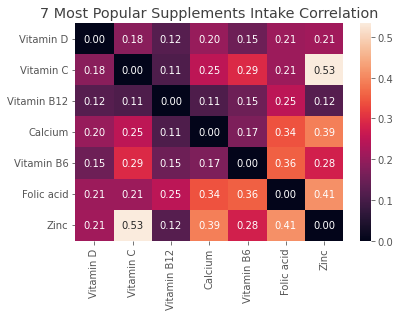

In [ ]:
import seaborn as sns

popular_ones = df_dietary_prepare.iloc[:, 0:7]
popular_ones.columns = ["Vitamin D", "Vitamin C", "Vitamin B12", "Calcium", "Vitamin B6", "Folic acid", "Zinc"]
popular_corr = popular_ones.corr()
np.fill_diagonal(popular_corr.values, 0)
print("mean corr among popular ones: ", np.sum(popular_corr.sum())/(len(popular_corr) * (len(popular_corr)-1)))
ax = sns.heatmap(popular_corr, annot=True, fmt=".2f")
# ax.title('pearson correlation among top 7 popular supplements')
# fig = ax.get_figure()
# fig.savefig('top7_heatmap.png')
plt.title('7 Most Popular Supplements Intake Correlation', color=plt.get_cmap('Greys')(0.8))
plt.savefig('top7_heatmap.png', dpi=500,bbox_inches = 'tight')

In [ ]:
# colormap refer to https://matplotlib.org/stable/tutorials/colors/colormaps.html
num_bars = 9
x = np.linspace(0, 5*num_bars, num_bars)
y = [len(df_dietary), df_dietary.loc[df_dietary["DSD010"] == 2].count()[0]]
y.extend(count[0:7]) 
x_label=["Total", "None", "VD", "VC", "VB12", "Calcium", "VB6", "Folic acid", "Zinc"]
colors = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7
plt.xticks(x, x_label)
plt.bar(x,y, width=3, color=colors)
plt.grid(False)
plt.title('Number of Respondents Having Different Supplements', color=plt.get_cmap('Greys')(0.8))
plt.savefig('dietary_barchart.png', dpi=500,bbox_inches = 'tight')
plt.show()

# Cross dataset correlation

## Correlations between pairs of continous variables

<BarContainer object of 9 artists>

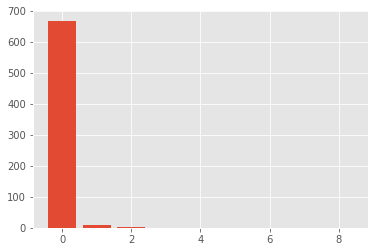

In [ ]:
df_corr = df_data.drop(columns = ["SEQN"]).corr(method = "spearman")
dfs = df_corr.stack()

corr_count = dict()
for corr in range(1, 10):
  corr_count[corr/10] = 0
  for a, v in zip(dfs.index, dfs):
    c1 = a[0]
    c2 = a[1]
    if c1 == c2 or check_which_data(c1) ==  check_which_data(c2) or abs(v) <corr/10:
      continue  
    corr_count[corr/10] += 1

plt.bar(np.arange(9), pd.Series(corr_count).values/2)

In [ ]:
print(corr_count)

{0.1: 1336, 0.2: 18, 0.3: 2, 0.4: 0, 0.5: 0, 0.6: 0, 0.7: 0, 0.8: 0, 0.9: 0}


In [ ]:
c = 0
for i, (a, v) in enumerate(zip(dfs.index, dfs)):
  if i > len(dfs)/2:
    break
  c1 = a[0]
  c2 = a[1]
  if c1 == c2 or check_which_data(c1) ==  check_which_data(c2) or abs(v) <0.22:
    continue  
  print(all_codes[c1], "(",c1,")-", check_which_data(c1), "is correlated with", all_codes[c2], "(",c2,")-",check_which_data(c2), "---",v)
  c += 1
print(c)

Total # of Dietary Supplements Taken ( DSDCOUNT )- diet is correlated with Number of foods/beverages reported ( DR1TNUMF )- nutrition --- 0.2308343099006234
Total # of Dietary Supplements Taken ( DSDCOUNT )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.25023287256478755
Calcium (mg) ( DSQTCALC )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.2516762159546641
Magnesium (mg) ( DSQTMAGN )- diet is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.2309082596469845
Number of foods/beverages reported ( DR1TNUMF )- nutrition is correlated with Total # of Dietary Supplements Taken ( DSDCOUNT )- diet --- 0.2308343099006234
Caffeine (mg) ( DR1TCAFF )- nutrition is correlated with ANTERIOR CARIES COUNT ( ANTERIOR_CARIES_COUNT )- dental --- 0.2284445216299341
Caffeine (mg) ( DR1TCAFF )- nutrition is correlated with POSTERIOR CARIES COUNT ( POSTERIOR_CARIES_COUNT )- dental --- 0.316604

Caffiene is correlated with both anteriour and posterior caries, that is expected.

## Insights via grouping continous variables according to categorical variables

In [ ]:
dfgd = df_data.drop(columns = ["SEQN"]).groupby("DR1LANG").describe()

Text(0.5, 1.0, 'Mean (in gm) Caffeine consumptions of\ndifferent Language speaking groups')

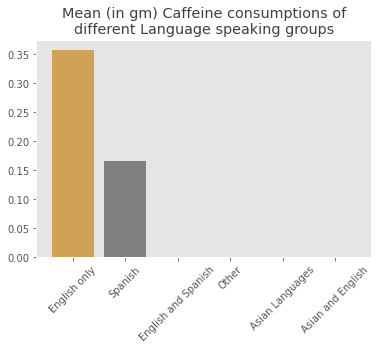

In [ ]:
num_bars = 9
x = dfgd[("DSQTCAFF", "mean")].index.values
y = dfgd[("DSQTCAFF", "mean")].values
# y.extend(count[0:7]) 
x_label=["English only", "Spanish", "English and Spanish", "Other", "Asian Languages", "Asian and English"]
colors = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7
plt.xticks(x, x_label, rotation = 45)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('Mean (in gm) Caffeine consumptions of\ndifferent Language speaking groups', color=plt.get_cmap('Greys')(0.8))

In [ ]:
dfgg = df_data.drop(columns = ["SEQN"]).groupby(["DSD010", "DR1MRESP"]).size()
a = []
for i in range (1, 12):
  if i == 4:
    continue
  a.append(dfgg[(2, i)])
a = np.array(a)/df_data.drop(columns = ["SEQN"]).groupby("DR1MRESP").count()["DSDCOUNT"].values

Text(0.5, 1.0, '% distribution of respondents who take supplements')

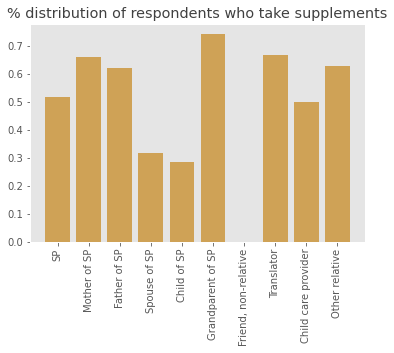

In [ ]:
y = a
x = np.arange(1, len(y)+1)
num_bars = len(x)
# y.extend(count[0:7]) 
x_label=['SP',
 'Mother of SP',
 'Father of SP',
 'Spouse of SP',
 'Child of SP',
 'Grandparent of SP',
 'Friend, non-relative',
 'Translator',
 'Child care provider',
 'Other relative']
colors = [plt.get_cmap('BrBG')(0.25)] * len(x)
plt.xticks(x, x_label, rotation = 90)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('% distribution of respondents who take supplements', color=plt.get_cmap('Greys')(0.8))

In [ ]:
dfgd = df_data.drop(columns = ["SEQN"]).groupby("DR1MRESP").describe()

Text(0.5, 1.0, 'Mean (in mg) Phosphorous Supplements taken')

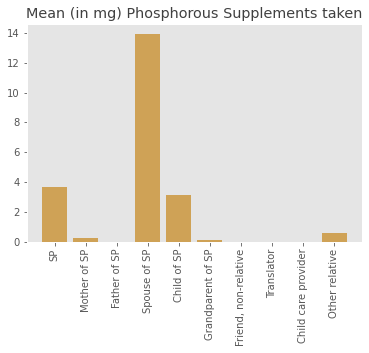

In [ ]:
y = dfgd[("DSQTPHOS", "mean")].values
x = np.arange(1, len(y)+1)
num_bars = len(x)
# y.extend(count[0:7]) 
x_label=['SP',
 'Mother of SP',
 'Father of SP',
 'Spouse of SP',
 'Child of SP',
 'Grandparent of SP',
 'Friend, non-relative',
 'Translator',
 'Child care provider',
 'Other relative']
colors = [plt.get_cmap('BrBG')(0.25)] * len(x)
plt.xticks(x, x_label, rotation = 90)
plt.bar(x,y, color=colors)
plt.grid(False)
plt.title('Mean (in mg) Phosphorous Supplements taken', color=plt.get_cmap('Greys')(0.8))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib as plt
from preprocess_dental import preprocess_dental_data
from data_preprocess import preprocess


In [ ]:
data = preprocess_dental_data(usage='01', set_index=True, drop_all_na=True, skipna=False)
data.describe()

/Users/kamehameya/UCSD/Courses/ECE 143/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return pd.read_sas(path if os.path.exists(path) else url)
/Users/kamehameya/UCSD/Courses/ECE 143/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  return pd.read_sas(path if os.path.exists(path) else url)
/Users/kamehameya/UCSD/Courses/ECE 143/dental_hygiene/preprocess_dental.py:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of callin

ANTERIOR_TOOTH_COUNT  POSTERIOR_TOOTH_COUNT  TOTAL_TOOTH_COUNT  \
count          12755.000000           12755.000000       12755.000000   
mean              10.838887              12.500274          23.339161   
std                2.983751               5.144294           7.532621   
min                0.000000               0.000000           0.000000   
25%               12.000000               9.000000          20.000000   
50%               12.000000              14.000000          26.000000   
75%               12.000000              16.000000          28.000000   
max               12.000000              20.000000          32.000000   

       ANTERIOR_CARIES_COUNT  POSTERIOR_CARIES_COUNT  TOTAL_CARIES_COUNT  \
count           11679.000000             9800.000000         8954.000000   
mean                1.704512                8.128061           10.021778   
std                 3.362081                5.672494            8.510732   
min                 0.000000                0.000000            0.000000   
25%                 0.000000                3.000000            3.000000   
50%                 0.000000                8.000000            8.000000   
75%                 2.000000               14.000000           15.000000   
max                12.000000               16.000000           28.000000   

       ANTERIOR_DENTAL_SEALANT_COUNT  POSTERIOR_DENTAL_SEALANT_COUNT  \
count                    2991.000000                     1607.000000   
mean                        0.004346                        1.669571   
std                         0.087598                        3.059756   
min                         0.000000                        0.000000   
25%                         0.000000                        0.000000   
50%                         0.000000                        0.000000   
75%                         0.000000                        2.000000   
max                         2.000000                       16.000000   

       TOTAL_SEALANT_COUNT  ROOT_CARIES  OTHER_NON_CARIOUS_ROOT_LESION  \
count          1587.000000  8001.000000                    7999.000000   
mean              1.686200     0.179353                       0.240280   
std               3.086166     0.420064                       0.503822   
min               0.000000     0.000000                       0.000000   
25%               0.000000     0.000000                       0.000000   
50%               0.000000     0.000000                       0.000000   
75%               2.000000     0.000000                       0.000000   
max              18.000000     2.000000                       2.000000   

       ANTERIOR_SIMPLE_01  POSTERIOR_SIMPLE_01  TOTAL_SIMPLE_01    SERIOUS_01  
count        12755.000000         12755.000000     12755.000000  12755.000000  
mean             0.392552             0.693375         0.712270      0.475186  
std              0.488338             0.461110         0.452722      0.499403  
min              0.000000             0.000000         0.000000      0.000000  
25%              0.000000             0.000000         0.000000      0.000000  
50%              0.000000             1.000000         1.000000      0.000000  
75%              1.000000             1.000000         1.000000      1.000000  
max              1.000000             1.000000         1.000000      1.000000

In [ ]:
colors = [plt.pyplot.get_cmap('BrBG')(0.25), 'grey'] + [plt.pyplot.get_cmap('BrBG')(0.25)] * 7

In [ ]:
data['TOTAL_CARIES_COUNT'].plot.hist(color=colors)

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

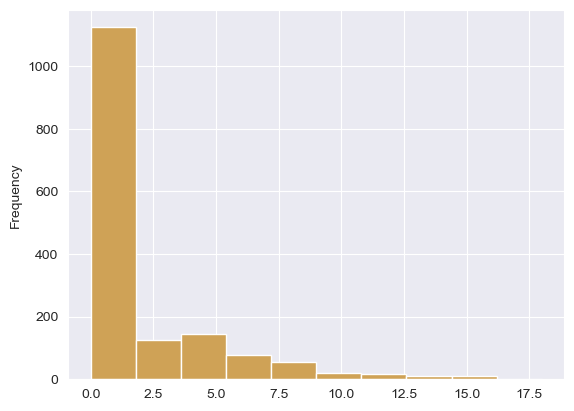

In [ ]:
data['TOTAL_SEALANT_COUNT'].plot.hist(color=colors)

<AxesSubplot:ylabel='Frequency'>

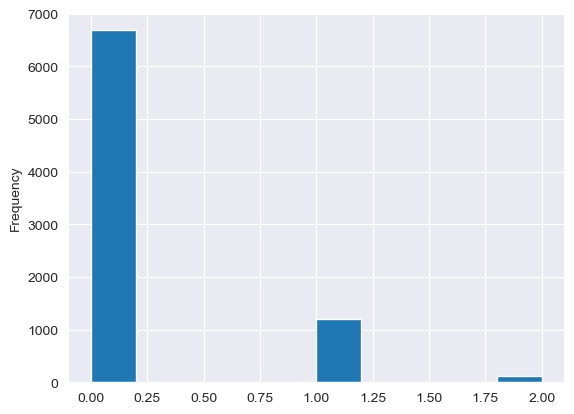

In [ ]:
data['ROOT_CARIES'].plot.hist()

In [ ]:
data['OTHER_NON_CARIOUS_ROOT_LESION'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

<AxesSubplot:ylabel='Frequency'>

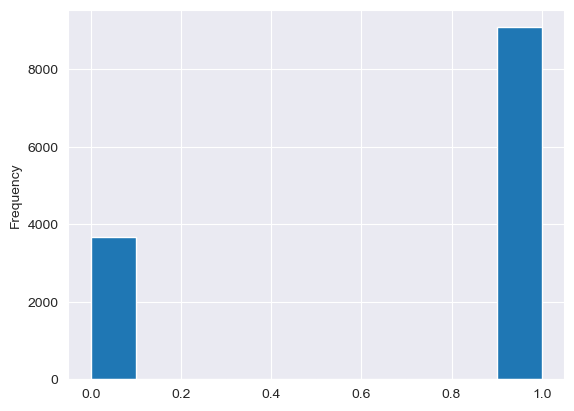

In [ ]:
data['TOTAL_SIMPLE_01'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

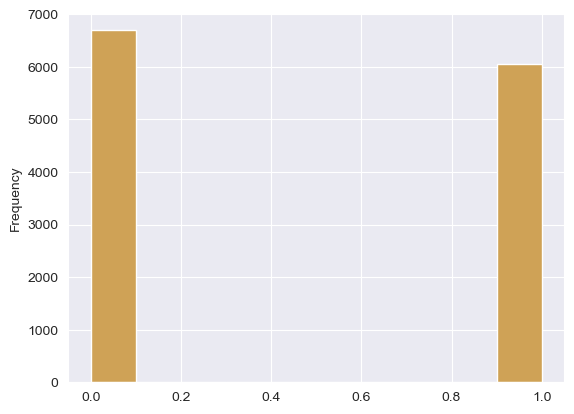

In [ ]:
data['SERIOUS_01'].plot.hist(color=colors)

In [ ]:
nutritions = []
df_nutritions = pd.concat([df_data.loc[:,"SEQN"], df_data.loc[:,"DSQTIODI":"DRD370V"]], axis = 1)
df_nutritions.info()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
final =[]
total_values1 = (sum(df_nutritions["DR1TMAGN"])+sum(df_nutritions["DR1TCAFF"])+sum(df_nutritions["DR1TFIBE"])+sum(df_nutritions["DR1TSODI"]))*0.001
total_values2 = sum(df_nutritions["DR1TCARB"])+sum(df_nutritions["DR1TPROT"])+sum(df_nutritions["DR1TSUGR"])+sum(df_nutritions["DR1TALCO"])+sum(df_nutritions["DR1TFIBE"])
total_values = total_values1+total_values2
final.append(100*0.001*sum(df_nutritions["DR1TMAGN"])/total_values)
final.append(100*sum(df_nutritions["DR1TCARB"])/total_values)
final.append(100*sum(df_nutritions["DR1TPROT"])/total_values)
final.append(100*0.001*sum(df_nutritions["DR1TCAFF"])/total_values)
final.append(100*sum(df_nutritions["DR1TSUGR"])/total_values)
final.append(100*sum(df_nutritions["DR1TALCO"])/total_values)
final.append(100*0.001*sum(df_nutritions["DR1TSODI"])/total_values)
final.append(100*sum(df_nutritions["DR1TFIBE"])/total_values)
y = np.array(final)
colors_grey = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7
colors = ["red", colors_grey[0], "black", "#4CAF50","orange","orange","blue","magenta"]
df_continuous_variables_labels_gms = ["Magnesium","Carbohydrate", "protein", "Caffeine","Total sugars","Alcohol","Sodium", "Dietary fiber"]

In [ ]:
import matplotlib.pyplot as plt
# The slices will be ordered and plotted counter-clockwise.
labels = [r'Magnesium (0.0597 %)', r'Carbohydrate (54.16 %)', 
r'Protein (16.4 %)', r'Caffeine (0.021%)',r'Total sugar (23.77 %)', r'Alcohol (1.416 %)', r'Sodium (0.72 %)', r'Dietary fiber (3.4 %)']
sizes = [88.4, 10.6, 0.7, 0.3]
colors = ["red", colors_grey[0], "black", "#4CAF50","orange","orange","blue","magenta"]
patches, texts = plt.pie(y, colors=colors, startangle=90)

plt.legend(patches, labels, loc="best") # The Legend

# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
#Bar chart for primary nutrients
[a1,b1,c1,a2,b2,c2,c3,a3,a4,b3,a5,a6,a7,b4,b5,b6,b7,c4,c5,c6,c7,d1,d2,d3,d4,d5,d6,d7] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
for index,d in df_nutritions.iterrows():
  if(d["DR1DAY"]==1):
    a1= a1+d["DR1TCARB"]
    b1= b1+d["DR1TPROT"]
    c1= c1+d["DR1TALCO"]
    d1= d1+d["DR1TCAFF"]
  elif(d["DR1DAY"]==2):
    a2= a2+d["DR1TCARB"]
    b2= b2+d["DR1TPROT"]
    c2= c2+d["DR1TALCO"]
    d2= d2+d["DR1TCAFF"]
  elif(d["DR1DAY"]==3):
    a3= a3+d["DR1TCARB"]
    b3= b3+d["DR1TPROT"]
    c3= c3+d["DR1TALCO"]
    d3= c3+d["DR1TCAFF"]
  elif(d["DR1DAY"]==4):
    a4= a4+d["DR1TCARB"]
    b4= b4+d["DR1TPROT"]
    c4= c4+d["DR1TALCO"]
    d4= c4+d["DR1TCAFF"]
  elif(d["DR1DAY"]==5):
    a5= a5+d["DR1TCARB"]
    b5= b5+d["DR1TPROT"]
    c5= c5+d["DR1TALCO"]
    d5= d5+d["DR1TCAFF"]
  elif(d["DR1DAY"]==6):
    a6= a6+d["DR1TCARB"]
    b6= b6+d["DR1TPROT"]
    c6= c6+d["DR1TALCO"]
    d6= d6+d["DR1TCAFF"]

  elif(d["DR1DAY"]==7):
    a7= a7+d["DR1TCARB"]
    b7= b7+d["DR1TPROT"]
    c7= c7+d["DR1TALCO"]
    d7= d7+d["DR1TCAFF"]
Y_carb = [a1/len(df_nutritions),a2/len(df_nutritions),a3/len(df_nutritions),a4/len(df_nutritions),a4/len(df_nutritions),a6/len(df_nutritions),a7/len(df_nutritions)]
Y_protein = [b1/len(df_nutritions),b2/len(df_nutritions),b3/len(df_nutritions),b4/len(df_nutritions),b5/len(df_nutritions),b6/len(df_nutritions),b7/len(df_nutritions)]
Y_alcohol = [c1/len(df_nutritions),c2/len(df_nutritions),c3/len(df_nutritions),c4/len(df_nutritions),c5/len(df_nutritions),c6/len(df_nutritions),c7/len(df_nutritions)]
Y_caffeine = [d1/len(df_nutritions),d2/len(df_nutritions),d3/len(df_nutritions),d4/len(df_nutritions),d5/len(df_nutritions),d6/len(df_nutritions),d7/len(df_nutritions)]
for k in range(len(Y_caffeine)):
 Y_caffeine[k] = Y_caffeine[k]/1000

In [ ]:
#computing the percentage increment of friday intake
#method1
Y_carb_avg = sum(Y_carb)/len(Y_carb)
Y_protein_avg = sum(Y_protein)/len(Y_protein)
Y_alcohol_avg = sum(Y_alcohol)/len(Y_alcohol)
Y_caffeine_avg = sum(Y_caffeine)/len(Y_caffeine)
p1 = (Y_carb[5]-Y_carb_avg)*100/Y_carb_avg
p2 = (Y_protein[5]-Y_protein_avg)*100/Y_protein_avg
p3 = (Y_alcohol[5]-Y_alcohol_avg)*100/Y_alcohol_avg
p4 = (Y_caffeine[5]-Y_caffeine_avg)*100/Y_caffeine_avg
p_friday = (Y_carb[5] + Y_protein[5]+Y_alcohol[5]+Y_caffeine[5])
p_overall_avg1 = (sum(Y_carb) + sum(Y_protein)+sum(Y_alcohol)+sum(Y_caffeine))/len(Y_carb)
print("Nutrients intake on friday")
print(p_friday)
print("Average intake for all days")
print(p_overall_avg1)
print("percentage increment of friday intake")
print((p_friday- p_overall_avg1)*100/p_overall_avg1)

import numpy as np 
import matplotlib.pyplot as plt 
  
X = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
  
X_axis = np.arange(len(X))
colors = [plt.get_cmap('BrBG')(0.25), 'grey'] + [plt.get_cmap('BrBG')(0.25)] * 7

plt.bar(X_axis - 0.2, Y_protein, 0.1, label = 'Proteins',color = colors[0])
plt.bar(X_axis - 0.1, Y_carb, 0.1, label = 'Carbs',color = 'brown')
plt.bar(X_axis , Y_caffeine, 0.1, label = 'Caffeine',color = "black")
plt.bar(X_axis+0.1 , Y_alcohol, 0.1, label = 'Alcohol',color = 'orange')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

plt.xticks(X_axis, X,rotation=45)
plt.xlabel(" Intake day of the week")
plt.ylabel("Quantity (gms)")
plt.title("Consumption to the intake day of the week")
plt.legend()
plt.show()

In [ ]:
#caries to the sugars
import matplotlib.pyplot as plt
import seaborn as sns
df_data =df_data[0:13000]
print(df_dental.columns)
df_corr = df_data[['POSTERIOR_TOOTH_COUNT', 'POSTERIOR_CARIES_COUNT'
       ,'DR1TSUGR']].corr()
ax = sns.heatmap(df_corr, annot=True, fmt=".3f")
plt.xticks(rotation = 70)